In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import sys, os
from os.path import join, dirname
main_dir = dirname(os.getcwd())
sys.path.append(main_dir)

In [3]:
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import casadi as ca # type: ignore
import si4kalman
from time import time
rng = np.random.default_rng(seed=42)

# Generate the problem

## Define the true model 

In [4]:
umax = 50
dt = 1.
model_true = si4kalman.minimal_model(dt, umax, Text=0.)
alphascale = 0.5
alpha_true = rng.random(model_true.nalpha)* alphascale # choose a "true parameter randomly"
beta_true = np.array([1e-1, 1e-2]) # Q, R

assert model_true.feasible(alpha_true, beta_true), "Constraints should be satisfied for the true parameters"

In [5]:
x0 = np.zeros(model_true.nx)
P0 = np.eye(model_true.nx) * 0.

## Generate Data 

In [41]:
Ntest = 100
Ntrain = 1000

us_train = model_true.generate_u(rng, Ntrain, umax=umax, step = 10)
ys_train, _ = model_true.simulation(x0, us_train, alpha_true,  beta_true, rng)

us_test = model_true.generate_u(rng, Ntest, umax=umax, step = 10)
ys_test, _ = model_true.simulation(x0, us_test, alpha_true, beta_true, rng)

<IPython.core.display.Javascript object>


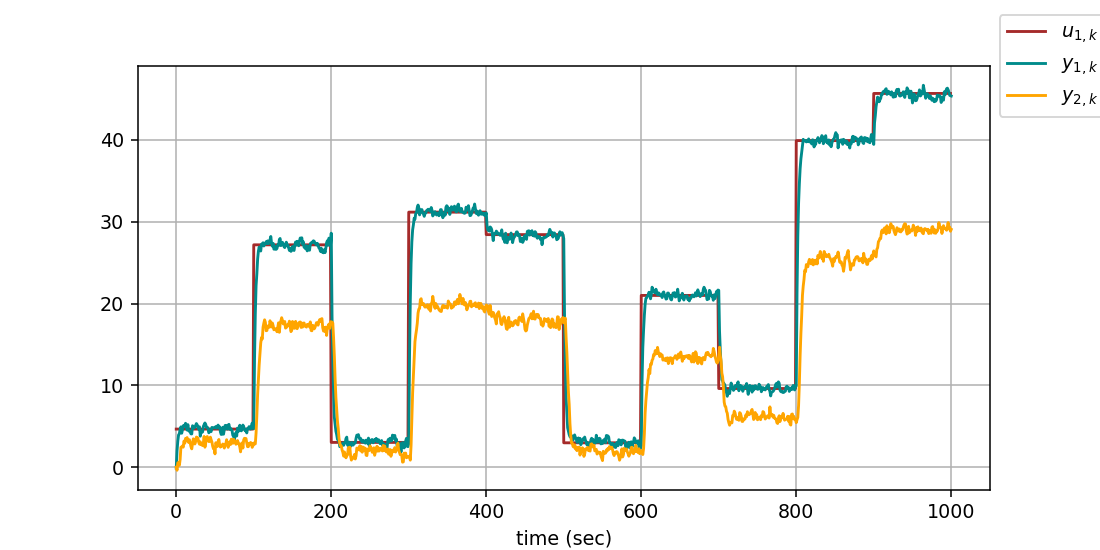

In [42]:
fig = si4kalman.plot_data(us_train, ys_train)

# Estimation

In [43]:
# Here we use the model that is assumed
model = si4kalman.minimal_model(dt, umax, Text=0., offset_free=False, min_beta=1e-6)
# the flag lti allow to speed things up for LTI systems 
problemTrain = si4kalman.ProblemParser(model, ys_train, us_train, x0, P0, lti=True)
problemTest = si4kalman.ProblemParser(model, ys_test, us_test, x0, P0)

In [44]:
# define the initial point for optimization
beta0 = np.ones(model.nbeta)
alpha0 = rng.random(model.nalpha)* alphascale

## Optimize over the Kalman filter 

In [45]:
formulation = "ExactSQP" # can be "ExactSQP", "ApproxSQP", "ExactIPOPT", "ApproxIPOPT"
opts = {"pen_step":1e-4, "maxiter":20, "tol.direction":0., "tol.kkt":1e-8} # these are parameters of the SQP algorithm

In [46]:
t0 = time()
alpha_found, beta_found, stats = problemTrain.solve(alpha0, beta0, formulation, opts, verbose=False)
rtime = time() - t0
print("running time : {:.2e}  status : {}".format(rtime, stats["return_status"]))

running time : 4.09e+00  status : rtol.cost_decrease


In [47]:
print( alpha_true, alpha_found)
print(beta_true, beta_found)

[0.38697802 0.21943922] [0.38668455 0.22111003]
[0.1  0.01] [0.10438323 0.01091716]


### Validation on out-of-sample data 

In [48]:
xs_est, ys_est = problemTest.kalman(alpha_found, beta_found)

npred = 3
t_pred, y_pred =  model.predictions(us_test, xs_est, alpha_found, npred)

<IPython.core.display.Javascript object>


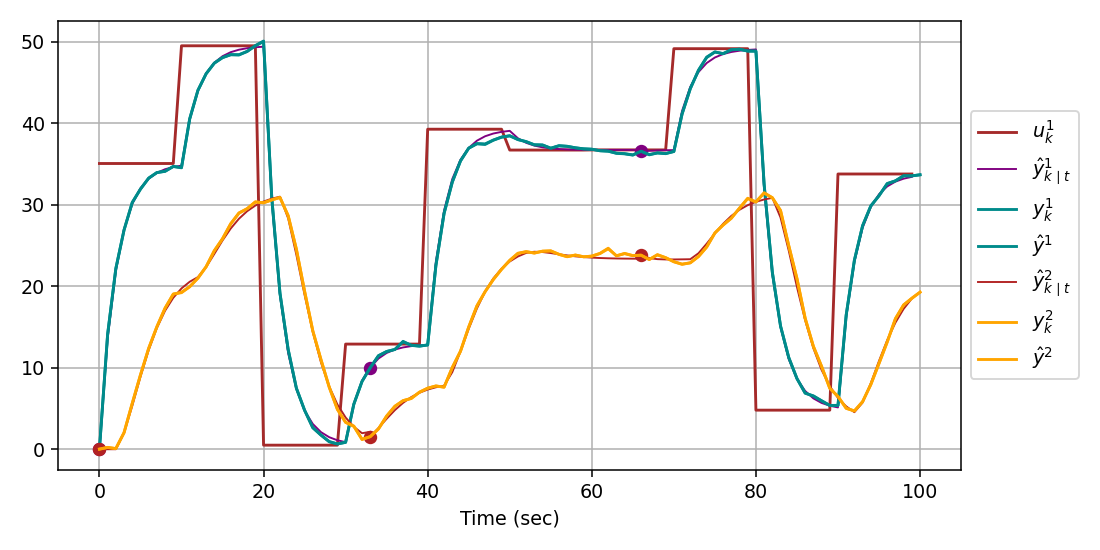

In [49]:
fig = si4kalman.plot_est(us_test, ys_test, ys_est, pred=(t_pred, y_pred))